<a href="https://colab.research.google.com/github/miltondp/k99_courses/blob/main/cis_522/classes/01_24-week2/CIS_522_W2D1_Tutorial_%E2%80%93_Student_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-522 Week 2 Part 1

# PyTorch & Deep Linear Networks

**Instructors:** Konrad Kording, Lyle Ungar

**Content creators:** Ameet Rahane, Spiros Chavlis, Ann-Katrin Reuel


---

# Today's agenda

In this tutorial of Week 2, we are going to dive a bit deeper into PyTorch. As a case study, we will use a simple linear regression model. Today we will:

1. Learn about the concept of auto differentiation
2. Implement a function for linear regression from scratch
3. Check the results with an analytical solution.


In [1]:
# @markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = "miltondp"  # @param {type:"string"}
my_pod = "Factorial Ferrets"  # @param ["Factorial Ferrets", "Causal Crows", "Recursive Roosters", "Bayesian Bighorns", "Probabilistic Pronghorns", "Hashing Hares", "Multiplicative Mustangs", "Curiosity Capybaras", "Subspace Salamanders"]
my_email = "miltondp@gmail.com"  # @param {type:"string"}
tutorial = "W2D1"


# start timing
import time

try:
    t0
except NameError:
    t0 = time.time()


---

# Setup


In [2]:
# imports
import numpy as np
import random
import matplotlib.pylab as plt
import matplotlib as mpl
import pandas as pd
from tqdm.notebook import tqdm, trange

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [3]:
# @title Figure Settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline 

fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [4]:
# @title Helper functions


def synthetic_dataset(w, b, num_examples=1000, sigma=0.01, seed=2021):
    """
    Synthetic data generator in the form:
        y = Xw + b + gaussian_noise(0, sigma).

    Parameters
    ----------
    w : torch.tensor
        weights. The length of `w` denotes the number of independent variables
    b : torch.tensor
        bias (offset or intercept).
    num_examples : INT, optional
        DESCRIPTION. The default is 1000.
    sigma : FLOAT, optional
        Standard deviation of the Gaussian noise. The default is 0.01.
    seed : INT, optional
        Seed the RNG for reproducibility. The default is 2021.

    Returns
    -------
    X: torch.tensor
        the independent variable(s).
    y: torch.tensor
        the dependent variable

    """

    torch.manual_seed(seed)

    X = torch.normal(0, 1, (w.shape[0], num_examples))
    y = torch.matmul(w.T, X) + b
    # Add gaussian noise
    y += torch.normal(0, sigma, y.shape)

    return X, y.reshape((-1, 1))


---

# Section 1: Deep Learning and Gradients


We clearly can run code. But now we want to be good enough at this so that we can solve our own problems. And to do so, we need to understand this from the bottom up.


Video available at https://youtube.com/watch?v=uyK1v8VIX4E


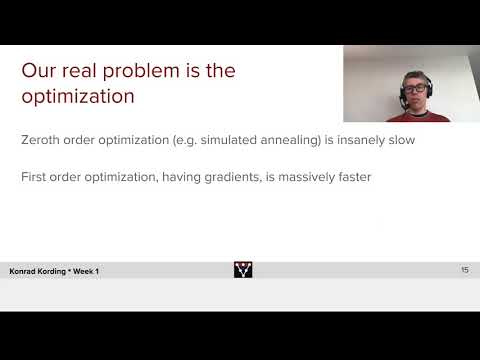

In [5]:
# @title Video: What is Deep Learning
from IPython.display import YouTubeVideo

try:
    t2
except NameError:
    t2 = time.time()

video = YouTubeVideo(id="uyK1v8VIX4E", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


## Why are Gradients important?

The gradient vector can be interpreted as the "direction and rate of fastest increase". In deep learning, we will use the gradient to optimize all of the parameters in a model with respect to some loss function. The partial derivative defines the gradient:

$$\dfrac{\partial loss}{\partial x}$$ where $x$ is the parameter we're optimizing.

So, what is a partial derivative? Looking back at single variable calculus, we know the ordinary derivative $\dfrac{df}{dx}$. In this function, $df$ is interpreted as some small change in the output of $f$, and $dx$ is is interpreted a small change in $x$.

However, if we have some multivariable function $f(x,y)$, $\dfrac{df}{dx}$ doesn't show how the entire function changes, so we call it a partial derivative, and for the sake of clarity, we denote this as $\dfrac{\partial f}{\partial x}$. When computing this partial derivative, we treat everything that's not what our partial derivative is with respect to as a constant. For example:

Let's compute the partial derivative $\dfrac{\partial f}{\partial x}$ of
$$f(x,y) = x^2y^3$$. We treat $y$ as a constant while doing this, so this is as simple as invoking the exponent rule from single variable calculus:

$$\dfrac{\partial f}{\partial x} = 2xy^3$$


## Let's work out a few partial derivatives to get the hang of it:

#### Given $f(x,y) = x^2 - xy$, find

1.  $\frac{\partial f}{\partial x} = 2x - y$

2.  $\frac{\partial f}{\partial y} = -x$


#### Given $f(x, y, z) = x - xy + z^2$, find

1.  $\frac{\partial f}{\partial x} = 1 - y$

2.  $\frac{\partial f}{\partial y} = -x$

3.  $\frac{\partial f}{\partial z} = 2z$


#### Given $f(x, y) = x e^{-2y} + x^2y$, find the **second** derivative

1.  $\frac{\partial ^2f}{\partial x^2} = 2y$

2.  $\frac{\partial ^2f}{\partial y^2} = -2xe^{-2y} + x^2 = 4xe^{-2y}$

3.  $\frac{\partial ^2f}{\partial x \partial y} = -2xe^{-2y} + x^2 = -2e^{-2y} + 2x$

4.  $\frac{\partial ^2f}{\partial y \partial x} = e^{-2y} + 2xy = -2e^{-2y} + 2x$


---

# Section 2: Gradients in Pytorch (Autograd)


Video available at https://youtube.com/watch?v=xBc95BB6Gwo


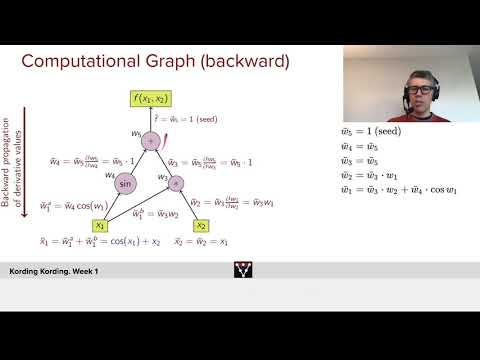

In [6]:
# @title Video: Automatic Differentiation

try:
    t3
except NameError:
    t3 = time.time()

video = YouTubeVideo(id="xBc95BB6Gwo", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


## AutoGrad

The `autograd` package provides automatic differentiation for all operations
on Tensors. It is a _define-by-run_ framework, which means that your backpropagation algorithm is defined by how your code is run and that every single iteration can be different.

Let us see this in more simple terms with some examples.


### Tensors

`torch.Tensor` is the central class of the package. If you set its attribute
`.requires_grad` as `True`, it starts to track all operations on it. When you finish your computation, you can call `.backward()` and have all the gradients computed automatically. The gradient for this tensor will be accumulated into `.grad` attribute.

To stop a tensor from tracking history, you can call `.detach()` to detach it from the computation history and prevent future computation from being tracked.

To prevent tracking history (and use of memory), you can also wrap the code block in `with torch.no_grad():`. This can be particularly helpful when evaluating a model because the model may have trainable parameters with `requires_grad=True`, for which we don't need the gradients.

There’s one more class which is very important for autograd implementation - a `Function`.

<img src="https://miro.medium.com/max/1536/1*wE1f2i7L8QRw8iuVx5mOpw.png" alt="Function" width="600"/>

`Tensor` and `Function` are interconnected and build up an acyclic graph, that encodes a complete history of computation. Each tensor has a `.grad_fn` attribute that references a `Function` that has created the `Tensor` (except for Tensors created by the user - their `grad_fn is None`).

If you want to compute the derivatives, you can call `.backward()` on a `Tensor`. If `Tensor` is a scalar (i.e., it holds a one element (data), you don’t need to specify any arguments to `backward()`, however, if it has more elements, you need to specify a `gradient` argument that is a tensor of matching shape.

On calling `.backward`, we get the gradients $\dfrac{\partial loss}{\partial x}$ where $x$ is the tensor. PyTorch will store the variable results in $x$.

---

PS: In previous versions of PyTorch, this required a separate Variable parameter that acted as a wrapper around a Tensor. This is now depreciated and `pytorch.Tensor` has autograd built-in.


Let's start from some toy examples.


In [7]:
ones_tensor = torch.ones(2, 2, requires_grad=True)
print(ones_tensor)

float_tensor = torch.FloatTensor(
    3, 3
)  # No way to specify requires_grad while initiating
float_tensor.requires_grad = True
print(float_tensor)


tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
tensor([[1.0065e-33, 0.0000e+00, 3.7835e-44],
        [0.0000e+00,        nan, 0.0000e+00],
        [1.3733e-14, 6.4069e+02, 4.3066e+21]], requires_grad=True)


**Important:** `requires_grad` option is _contagious_, i.e., when a Tensor is created by operating on other Tensors, the `requires_grad` of the resultant Tensor would be set `True` given that at least one of the tensors used for its creation has `requires_grad` set to `True`.


_So_, what we have just built is a tensor with the autograd option enabled. As a toy example, assume that we want to differentiate the function $y=4\textbf{x}^{\text{T}}\textbf{x}$ with respect to the column vector $\textbf{x}$.


In [49]:
x = torch.arange(4.0, requires_grad=True)
print(x)
print(x.grad)


tensor([0., 1., 2., 3.], requires_grad=True)
None


Now, we calculate the value of $y$


In [50]:
y = 4 * torch.dot(x, x)
print(y)


tensor(56., grad_fn=<MulBackward0>)


Since $\textbf{x}$ is a vector of length 4, an inner product of $\textbf{x}$ with itself is performed, yielding the scalar output that we assign to $y$. Next, we can automatically calculate the gradient of $y$ with respect to each component of $\textbf{x}$ by calling the function for backpropagation and printing the gradient.


In [51]:
y.backward()
x.grad

tensor([ 0.,  8., 16., 24.])

Milton:
* if I ran the previous cell again, it will throw an error, because I try to "backward through the graph a second time".
* if I ran the previous two cells again, the gradient of x keep accumulating, adding the gradient each time I run it again.
* I have to run the three previous cells to get the same results again.

The gradient of the function $y=4 \textbf{x}^{\text{T}} \textbf{x}$ with respect to $\textbf{x}$ should be $8\textbf{x}$. Let us quickly verify that our desired gradient was calculated correctly.


In [52]:
x.grad == 8 * x


tensor([True, True, True, True])

In [56]:
# PyTorch accumulates the gradient in default, we need to clear the previous
# values
# Milton: so x.grad.zero_() put zeros and allows to by pass the error of running
#   .backward again (as I had before)
x.grad.zero_()
y = x.sum()
y.backward()
x.grad


tensor([1., 1., 1., 1.])

## Autograd: the importance and history of autograd

Autograd came to be simply because it is impractical and challenging to both visualize and compute gradients for very high dimensional spaces, such as those we'd see in large neural networks:

> "To deal with hyper-planes in a 14-dimensional space, visualize a 3-D space and say ‘fourteen’ to yourself very loudly. Everyone does it" - Geoffrey Hinton.

Autograd abstracts these concepts and "automagically" calculates gradients of high dimensional spaces. Gradients care calculated by tracing the computation graph from the root (the first tensor created) to the leaf (the last computation that occurred) and using the chain rule to compute every gradient along the way.

Let's look at some of the relevant functions and attributes:

-   `.detach()`: Detaches the tensor from the computation graph and prevents future computation from being tracked
-   `.requires_grad`: Starts tracking all operations on the computation graph
-   `.backward()`: When the computation is finished, call `tensor.backward()` to compute all gradients automatically
-   `.grad`: All of the gradients for each tensor is accumulated in `.grad`
-   `.grad_fn`: For tensors created by an operation, `grad_fn` will give you the operation that created them. For tensors created by users, it will return None.
-   `.requires_grad_(bool)`: Changes an existing Tensor's `requires_grad` flag in place. This is False by default.

See: https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html


## Example: A small Compute Graph


### Forward pass

PyTorch creates a so-called **Dynamic Computation Graph**, which means that the graph is generated on the fly.

The big thing that differentiates PyTorch and Tensorflow is how the computation graph functions. In PyTorch, all variables and functions build a dynamic graph of computation. For every mathematical operation involving Tensors, a Function node is made on this computation graph. We can see what function creates a given Tensor by using the attribute `grad_fn`. So, let's examine the compute graph of a simple addition operation.

<img src="https://miro.medium.com/max/1684/1*FDL9Se9otGzz83F3rofQuA.png" alt="Computation Graph" width="500"/>

Here, we give a toy example with an elementary graph to understand PyTorch's logic!

The variable $\alpha$ is the input and is initialized by the user. Variables $b$, $c$ and $d$ are created as a result of mathematical operations, variables $w_1$, $w_2$, $w_3$ and $w_4$ are initialised by the user. Since any mathematical operator does not create them, nodes corresponding to their creation are represented by their name itself. This is true for all the leaf nodes in the graph. Variable $L$ is the output of this computational graph.


#### Exercise 2a: Get the parameters

Lets start by defining our parameters ($w_1, w_2, w_3, w_4$) and inputs ($\alpha$). Lets assume that all parameters and inputs are $3 \times 3$ tensors sampled from a normal distribution with zero mean and standard deviation $\sigma=1$ (i.e., `torch.randn`).

_Hint:_ Do not forget to enable tracking of gradients.

_Clarification:_ With respect to this graph, we further assume that all multiplications are pointwise and that L is the MSE loss between d and target.


In [59]:
def get_params():
    """
    A simple function that generates our parameters and inputs

    ---
    args: nothing

    returns:
      a: torch.Tensor
        inputs
      w1: torch.Tensor
        weights
      w2: torch.Tensor
        weights
      w3: torch.Tensor
        weights
      w4: torch.Tensor
        weights

    """
    #####################################################################
    # Fill in missing code (...) with randomly initialized tensors
    # (standrad normal) which require gradient.
    # then remove or comment the line below to test your function.
    #raise NotImplementedError("Define the input and weight params!")
    #####################################################################
    a = torch.randn(3, 3, requires_grad=True)
    w1 = torch.randn(3, 3, requires_grad=True)
    w2 = torch.randn(3, 3, requires_grad=True)
    w3 = torch.randn(3, 3, requires_grad=True)
    w4 = torch.randn(3, 3, requires_grad=True)

    return (a, w1, w2, w3, w4)


# uncomment the lines below to test your function
params = get_params()
print(f'The inputs are: \n{params[0]}')
print(f'The weights are: \nw1:{params[1]}, \nw2:{params[2]}, \nw3:{params[3]}, '
      f' \nw4:{params[4]}')


The inputs are: 
tensor([[ 0.3768, -1.3984,  0.6144],
        [-1.6706,  0.6962, -0.9105],
        [-0.8252, -1.4441,  1.1158]], requires_grad=True)
The weights are: 
w1:tensor([[-1.1494,  0.0269,  0.6037],
        [ 1.8070, -0.1105,  0.2772],
        [ 0.4429,  0.1340, -0.6715]], requires_grad=True), 
w2:tensor([[-1.5171,  0.8184, -0.8973],
        [ 0.6101, -0.1574,  2.1727],
        [ 0.1413, -1.4661,  0.7534]], requires_grad=True), 
w3:tensor([[ 0.4962,  0.7484,  0.3984],
        [-0.8071, -0.0949, -0.5399],
        [-1.7903, -1.0955, -0.9865]], requires_grad=True),  
w4:tensor([[ 1.5155,  0.8599, -0.0341],
        [ 0.8042,  1.2263, -0.7546],
        [ 0.1859,  0.5553, -1.0056]], requires_grad=True)


#### Exercise 2b: Compute graph

Now, let's define the mathematical operations of our toy graph. Weights are multiplied with the corresponding node value, and double arrows denote a summation (see node $d$).

_Clarification:_ With respect to this graph, we further assume that all multiplications are pointwise and that L is the MSE loss between d and target.


In [72]:
def compute_graph(params, target):
    """
    Simple function with the forward pass

    args:
      params: list
        contains the inputs and the weight tensors
    returns:
      L: float
        loss given a target value
    """
    a, w1, w2, w3, w4 = params[0], params[1], params[2], params[3], params[4]

    #####################################################################
    # Fill in missing code (...) to create the compute graph
    # shown in Example A (above).
    # then remove or comment the line below to test your function.
    #raise NotImplementedError("Define the compute graph!")
    #####################################################################

    b = a * w1
    c = a * w2
    d = (b * w3) + (c * w4)

    # Compute the summed loss
    L = ((target - d) ** 2).mean()

    mse = nn.MSELoss()
    L_true = mse(d, torch.tensor(target))
    print(L_true)

    # Store weights in a dictionary
    weights = {}
    weights["w1"] = w1
    weights["w2"] = w2
    weights["w3"] = w3
    weights["w4"] = w4

    # Store values of the nodes in a dictionary
    values = {}
    values["a"] = a
    values["b"] = b
    values["c"] = c
    values["d"] = d

    return (L, values, weights)


# uncomment the following lines to test your function
output = compute_graph(params, 20)
print(f'Loss: {output[0]}')


tensor(387.2888, grad_fn=<MseLossBackward0>)
Loss: 387.2887878417969


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([3, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Now, let's print the gradients.


In [74]:
a = output[1]["a"]
d = output[1]["d"]

print("The grad fn for a is", a.grad_fn)
print("The grad fn for d is", d.grad_fn)


The grad fn for a is None
The grad fn for d is <AddBackward0 object at 0x7fd422ade340>


What you see is that the gradient for the input `a` is `None` as we did not calculate it yet! Let's first see what PyTorch computes as gradients of any computational graph.


### Backward pass: Computing the gradients

Each node of the computation graph, with the exception of leaf nodes, can be considered as a function which takes some inputs and produces an output. Consider the node of the graph which produces variable $d$ from $w_3 \cdot b$ and $w_4 \cdot c$. Thus, we can write the output $d$ as a function of its inputs:

\begin{equation}
d = f(w_3 \cdot b, w_4 \cdot c)
\end{equation}

Thus, we can easily compute the gradient of the function $f$ with respect to its inputs ($\frac{\partial f}{\partial w_3b}$ and $\frac{\partial f}{\partial w_4c}$). Similarly, we do this for the entire graph and we have described the derivatives of this graph.

<img src="https://miro.medium.com/max/1684/1*EWpoG5KayZSqkWmwM_wMFQ.png" alt="Computation Graph with Gradients" width="500"/>

In order to compute derivatives in our graph, we generally call `backward` on the Tensor representing our loss $L$, i.e., the output of the graph. Then, we backtrack through the graph starting from the node representing the `grad_fn` of our loss.

As described above, the backward function is recursively called throughout the graph as we backtrack. Once, we reach a leaf node, since the `grad_fn` is `None`, but stop backtracking through that path.


In [76]:
L = output[0]
L.backward()


Once that's done, you can access the gradients by calling the Tensor's `grad` attribute.


In [77]:
a.grad


tensor([[ 40.3294, -10.1398,  -3.5850],
        [ 11.8604,   2.4496,  21.9141],
        [  9.8995,  11.9242,   1.2765]])

In [78]:
w1 = output[2]["w1"]
w1.grad


tensor([[ -2.6281,  14.6604,  -3.2368],
        [-16.5251,   0.8862,  -6.0205],
        [-19.0764, -19.6295,  14.7532]])

Understanding how **Autograd** and **computation graphs** works can make your life easier. With our foundations rock-solid, we can proceed and see these components in action. Let's start with the simplest case; _Linear regression_.


---

# Section 3: Gradients as part of optimization; first order techniques


Video available at https://youtube.com/watch?v=oQcrIgtqlXU


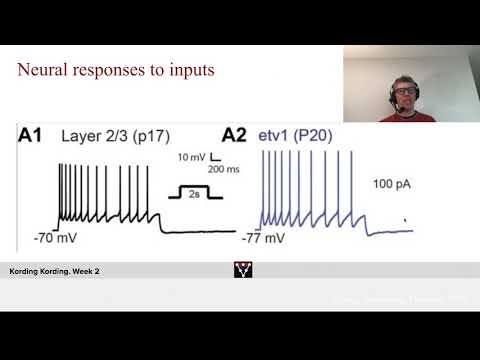

In [95]:
# @title Video: Linear Regression and Neuroscience

try:
    t4
except NameError:
    t4 = time.time()

video = YouTubeVideo(id="oQcrIgtqlXU", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video


## Section 3.1: Linear Regression


Video available at https://youtube.com/watch?v=h5H8A3ZFuI4


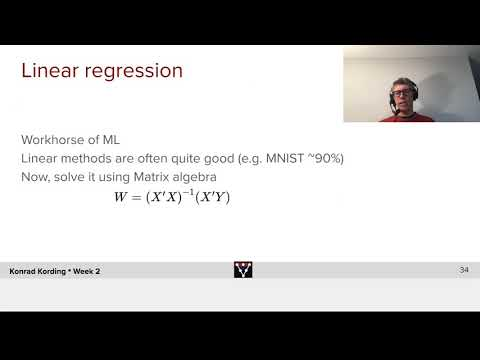

In [96]:
# @title Video: Linear Regression and Matrix Inversion
video = YouTubeVideo(id="h5H8A3ZFuI4", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


Generally, _regression_ refers to a set of methods for modeling the relationship between one (or more) independent variable(s) and one (or more) dependent variable(s). Regression is commonly applied when we want to find the relationship between the dependent and the independent variables. For example, if we want to examine the relative impacts of age, gender, and diet (the independent variables) on height (the dependent variable). On the other hand, a regression can be used for predictive analysis. Thus the independent variables are also called predictors. When the model contains more than one predictor, then the method is called _multiple regression_, and if it contains more than one dependent variable called _multivariate regression_.

Regression problems pop up whenever we want to predict a numerical (usually continuous) value.

The independent variables are collected in a vector $\mathbf{x} \in \mathbb{R}^D$, where $D$ denotes the number of independent variables. Each variable influences differently the dependent variable by a weight factor, $w_{d}$. Thus, $\mathbf{w} \in \mathbb{R}^D$.

The multiple regression model can be written as:

\begin{equation}
y = w*{1}x*{1} + w*{2}x*{2} + \dots + w*{D}x*{D} + b = \sum*{d=1}^D \left(w*{d}x\_{d} \right) + b
\end{equation}

Thus, the model can be written in matrix format as:

\begin{equation}
y = \begin{bmatrix} w*{1} & w*{2} & \dots & w*{D} \end{bmatrix} \begin{bmatrix} x*{1} \\ x*{2} \\ \vdots \\ x*{D} \\ \end{bmatrix} + b
\end{equation}

Which can be written in a compact form as:
\begin{equation}
y = \mathbf{w}^{\text{T}}\mathbf{x} + b
\end{equation}

where $\text{w}$ is the weight and $b$ is the bias (also known as intercept). Notice that $x$ is a matrix with the independent variables in rows and different examples stack in columns.

First, lets plot our synthetic dataset, using $w=2.5$ and $b=1.2$. We will also add gaussian noise with standard deviation $\sigma$ to make the synthetic data more realistic.

\begin{equation}
y = \mathbf{w}^{\text{T}}\mathbf{x} + b + \epsilon
\end{equation}

where

\begin{equation}
\epsilon \sim \mathcal{N}(\mu=0, \sigma)
\end{equation}

### Gaussian distribution

To refresh our memory, the probability density of a normal distribution with mean $\mu$ and standard deviation $\sigma$ is given by:

\begin{equation}
p(x)=\frac{1}{2\pi\sigma^{2}} \exp \left(-\frac{(x-\mu)^{2}}{2\sigma^{2}}\right)
\end{equation}

Here, we will start from the simplest case, where we want to perform regression using one predictor (**x**) and one dependent variable (**y**). Thus, the model is given by the formula:

\begin{equation}
y = w\_{1}x + b + \epsilon
\end{equation}


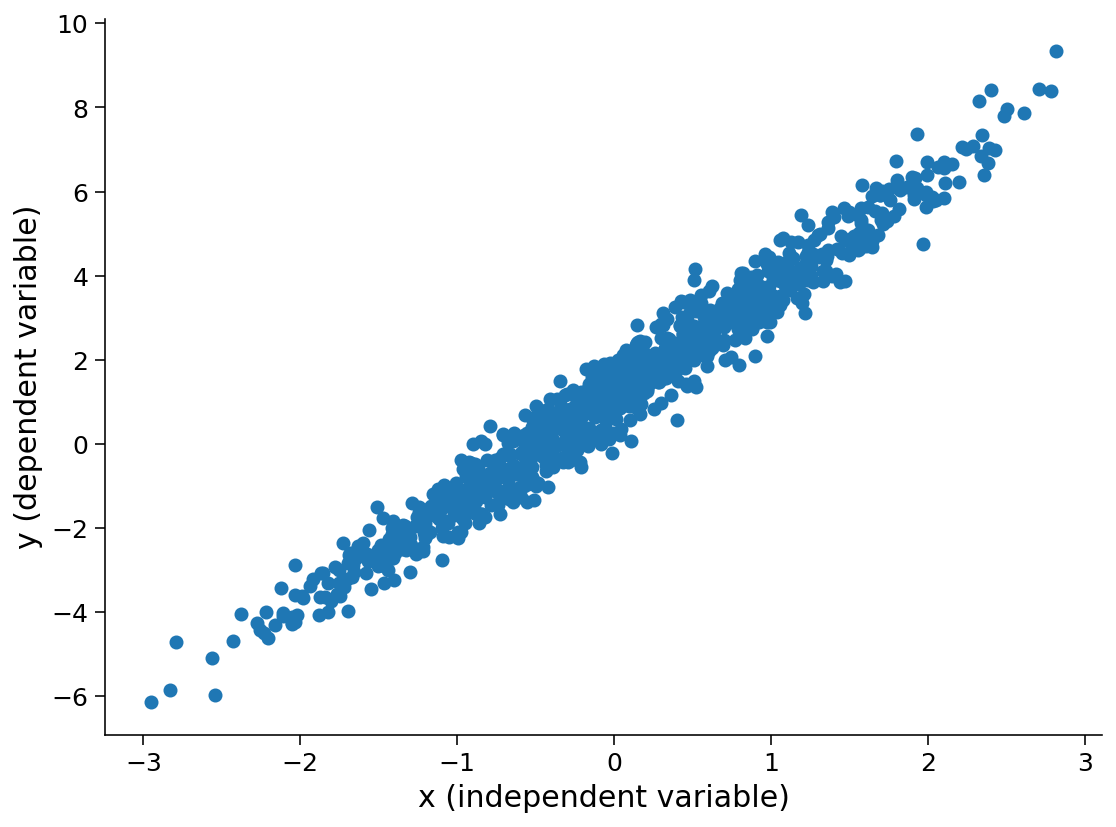

In [97]:
# This is the code block to generate random data for linear regression

original_w = torch.tensor([2.5]).reshape(-1, 1)
original_b = 1.2
N = 1000  # number of examples
X, y = synthetic_dataset(original_w, original_b, num_examples=N, sigma=0.5)

plt.figure()
plt.scatter(X, y)
plt.xlabel("x (independent variable)")
plt.ylabel("y (dependent variable)")
plt.show()


## Section 3.2: Vectorized regression

Now, having a lot of data, we can collect them in a matrix $\mathbf{X} \in \mathbb{R}^{D \times N}$,. Thus, linear regression takes the following form:

\begin{equation}
\mathbf{Y} = \mathbf{w}^{\text{T}}\mathbf{X} + b
\end{equation}

where broadcasting is applied in the summation, i.e., $b$ broadcasts in a $D$-dimensional vector with the values $b$ in every position.

Let's write the code for our model.


### Exercise 3a: Write the linear regression model


In [98]:
def linear_regression(X, w, b):
    """
    Linear regression model.

    Parameters
    ----------
    X : torch.tensor
        design matrix.
    w : torch.tensor
        weights.
    b : torch.tensor
        bias.

    Returns
    -------
    torch.tensor
      predicted values.

    """
    #####################################################################
    # Fill in missing code (...),
    # then remove or comment the line below to test your function.
    #raise NotImplementedError("Complete the linear_regression function")
    #####################################################################
    reg = w.T @ X + b
    return reg


# uncomment the lines below to test your function
print(linear_regression(X[:,0].reshape(1,-1), original_w, original_b))


tensor([[0.8370]])


## Section 3.3: Loss function

First, we need to determine a measure of fitness. In simple words, we want to quantify if our model performs good or bad given some parameters $w$ and $b$. The so-called _loss function_ quantifies the distance between the real and predicted values of the target. The loss will usually be a non-negative float number (as you will see later on, some applications can also contain negative losses). Small values are better and perfect predictions incur a loss of 0. The most popular loss function in regression problems is the **squared error**. When our prediction for an example $\mathbf{x}^{[i]}$ is $\hat{y}^{[i]}$ and its corresponding true value is $y^{[i]}$ , the squared error is given by:

\begin{equation}
l^{[i]}=\left(\hat{y}^{[i]} - y^{[i]}\right)^{2}
\end{equation}

Usually, our datset consits of lots of data, thus we sum up all individual squred error. Generally, we take out the average of all these erros, thus, gien that we have $N$ data points the _mean squared error_ (MSE) is given by:

\begin{align}
L(\mathbf{w}, b) &{}= \frac{1}{N} \sum*{i=1}^{N} l^{[i]} \\
&{}= \frac{1}{N} \sum*{i=1}^{N} \left(\hat{y}^{[i]} - y^{[i]}\right)^{2} \\
&{}= \frac{1}{N} \sum\_{i=1}^{N} \left(\mathbf{w}^{\text{T}}\mathbf{x}^{[i]} + b - y^{[i]}\right)^{2}
\end{align}

Our aim here is to choose the parameters so that the error will be minimized. In mathematical terms, this is translated into a minimization problem with respect to parameters $\mathbf{w}$ and $b$:

\begin{equation}
\mathbf{w^{_}}, b^{_} = \underset{\mathbf{w},b}{\mathrm{argmin}} \left( L(\mathbf{w}, b) \right)
\end{equation}

Let's implement a function that calculates the mean squared error.


### Exercise 3b: Squared Error calculation


In [99]:
def squared_error(y_hat, y):
    """
    Squared error loss function.

    Parameters
    ----------
    y_hat : torch.tensor
        predicted values.
    y : torch.tensor
        true values.

    Returns
    -------
    err: FLOAT
         the squared error (loss)

    """
    #####################################################################
    # Fill in missing code (...),
    # then remove or comment the line below to test your function.
    # raise NotImplementedError("Complete the squared_error function")
    #####################################################################
    err = ((y - y_hat) ** 2)
    return err


# uncomment the lines below to test your function
print(squared_error(torch.tensor([2, 1, 7]), torch.tensor([1,-1, 7.5])))


tensor([1.0000, 4.0000, 0.2500])


## Section 3.3.1 Analytic Solution by Matrix Inversion

As you can see from the equation above, linear regression is a relatively simple optimization problem. Unlike most other models that we will see in this course, linear regression can be solved analytically by applying a simple formula.

To further simplify things, we can subsume the bias $b$ into the parameter $\textbf{w}$ by appending an extra fake dimension equal to one to our data points $\textbf{x}$. Thus, the vectors $\textbf{x} \in \mathbb{R}^{D+1}$.

So, using matrix notation, the optimization problem is given by:

\begin{align}
\mathbf{w^{\*}} &{}= \underset{\mathbf{w}}{\mathrm{argmin}} \left( ||\textbf{Y} - \textbf{X}\textbf{w}||^2 \right) \\
&{}= \underset{\mathbf{w}}{\mathrm{argmin}} \left( \left( \textbf{Y} - \textbf{X}\textbf{w}\right)^{\text{T}} \left( \textbf{Y} - \textbf{X}\textbf{w}\right) \right)
\end{align}

where $\textbf{X} \in \mathbb{R}^{N \times D}$, the so-called design matrix.

Thus, the minimization problem is to set the derivative of the loss with respect to $\textbf{w}$ to zero.

\begin{equation}
\frac{\partial L(\textbf{w})}{\partial \textbf{w}} = 0
\end{equation}

Assuming that $\textbf{X}^{\text{T}}\textbf{X}$ is full-rank and thus its inverse exists (implying that $N>D$ and the rows are not all linearly dependent:

\begin{equation}
\textbf{w}^{\textbf{\*}} = \left( \textbf{X}^{\text{T}}\textbf{X} \right)^{-1}\textbf{X}^{\text{T}}\textbf{Y}
\end{equation}

**Note**: for the analytic proof, see the [Appendix](#proof).


### Exercise 3c: Write the analytical solution of the linear regression

So, let's write a function that calculates the analytic solution of the linear regression problem given that we have a dataset $X$ and the target variables $y$.

_Hint_: What is the determinant (`np.linalg.det`) of a non-invertible matrix?


In [100]:
def analytical_sol(X, y):
    """
    Squared error loss function.

    Parameters
    ----------
    X : numpy.ndarray (float)
        design matrix with dimensions NxD, D: features, N: examples.
    y : numpy.ndarray (float)
        target values.

    Returns
    -------
    params: numpy.ndarray
            the parameters w, and bias (last element)

            if `X.T @ X` is singular, returns nothing.
    """

    # Check if the inverse exists, unless print error.

    params = []
    #####################################################################
    # Fill in missing code (...),
    # then remove or comment the line below to test your function.
    # IMPORTANT: Write the condition to check if the matrix is invertible.
    #raise NotImplementedError("Write the condition and the formula")
    #####################################################################
    # X = np.c_[1, X]
    Xt_X = X.T @ X

    if np.linalg.det(Xt_X) != 0:
        params = np.linalg.pinv(Xt_X) @ X.T @ y
    else:
        print("LinAlgError. Matrix is Singular. No analytical solution.")

    return params


# tiny dataset
alpha, beta = -2.0, 1.4
xsynth = np.linspace(-1, 1, 10).reshape(-1, 1)  # 100 examples, in 10D space
ysynth = alpha * xsynth + beta  # target values
xsynth_append = np.hstack((xsynth, np.ones((10, 1))))  # Append a column with `1`

# uncomment the lines below to test the analytical solution
params = analytical_sol(xsynth_append, ysynth)
print(f'Original: alpha={alpha} and beta={beta}')
print(f'Estimated: alpha={params[0].item()} and beta={params[1].item()}')


Original: alpha=-2.0 and beta=1.4
Estimated: alpha=-1.9999999999999998 and beta=1.4000000000000001


## Section 3.4: Gradient descent

Linear regression has a closed-form solution; however, this is not the case in most machine learning applications. When we cannot solve the models analytically, it turns out that we can still train models effectively in practice.

The key technique for optimizing nearly any deep learning model consists of iteratively reducing the error by updating the direction's parameters that incrementally lowers the loss function. This algorithm is called _gradient descent_.

The most naive application of gradient descent consists of taking the derivative of the loss function, an average of the losses computed on every single example in the dataset.

We define the gradient of a multi-variable function $f(\theta)$ as $$\nabla f(\theta) = \begin{bmatrix} \dfrac{\partial f(\theta)}{\partial \theta_0} \\ \dfrac{\partial f(\theta)}{\partial \theta_1} \\ \vdots \\ \dfrac{\partial f(\theta)}{\partial \theta_D} \\ \end{bmatrix}$$

Gradient Descent attempts to find the minima of a given function $f(\theta)$ by descending to the gradient's opposite direction.

It updates the parameters in an iterative fashion in the opposite direction of the gradient. First, we need an initial guess $x_0$ of the solution (often this is randomly initialized). Then, we calculate the gradient with the function evaluated at $x_0$. The update rule is as follows:
\begin{equation}
\theta^{\text{new}} = \theta^{\text{old}} - \eta \nabla f(\theta^{\text{old}})
\end{equation}
where $\eta$ is the learning rate, how fast or slow the model learns.

In our simple example, our model consists of two parameters, $w$ and $b$, thus, the gradient descent can be written:

\begin{equation}
w \leftarrow w - \eta \frac{\partial }{\partial w} L(w,b) \\
b \leftarrow b - \eta \frac{\partial }{\partial b} L(w,b)
\end{equation}

We start with $w=0$ and $b=0$.


In [101]:
def gradient_descent(w, b, lr):
    """
    gradient_descent algorithm.

    Parameters
    ----------
    w : torch.tensor
        weights.
    b : torch.tensor
        bias.
    lr : FLOAT
        learning rate.

    Returns
    -------
    w, b.

    """
    with torch.no_grad():
        w -= w.grad * lr
        b -= b.grad * lr
        # Set gradient to zero to flush the cache
        w.grad.zero_()
        b.grad.zero_()

    return (w, b)


## Section 3.5: Training

Here, we will write from scratch the training loop. First, we choose the learning rate and the number of epochs, and we define the loss function. Then, we initialize the parameters. We use a list `losses` to record the mean-squared error after each **epoch** (with **epoch**, we denote a full pass of the data set through the network).


loss:   0%|          | 0/100 [00:00<?, ?it/s]

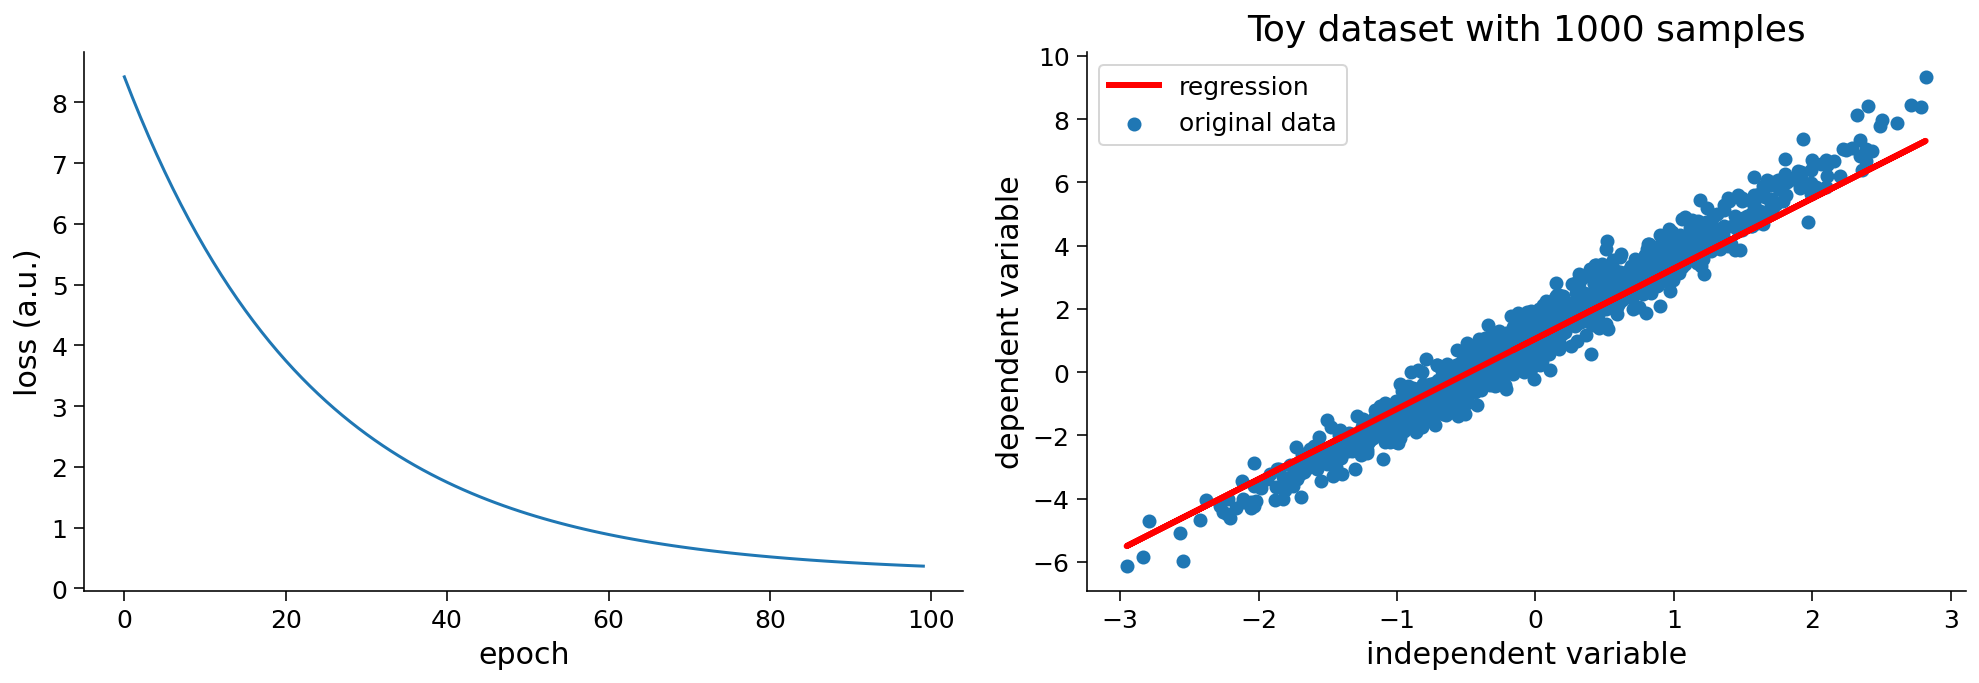

In [116]:
lr = 1e-2  # learning rate
num_epochs = 1000  # number of epochs (updates)
net = linear_regression
loss = squared_error

y_train = y.squeeze()  # to avoid wrong broadcasting

w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

losses = []

epoch_range = trange(num_epochs, desc="loss: ", leave=True)

for epoch in epoch_range:
    if losses:
        epoch_range.set_description("loss: {:.6f}".format(losses[-1]))
        epoch_range.refresh()  # to show immediately the update

    y_hat = net(X, w, b)
    l = loss(y_hat, y_train).mean()  # Loss in `X` and `y`

    # Compute gradient on `l` with respect to `w`, `b`
    l.backward()
    w, b = gradient_descent(w, b, lr)  # Update parameters using their gradient

    losses.append(l.detach())

    time.sleep(0.01)

w_train = w
b_train = b
y_hat = net(X, w_train, b_train).reshape(-1, 1)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), losses)
plt.xlabel("epoch")
plt.ylabel("loss (a.u.)")

plt.subplot(1, 2, 2)
plt.scatter(X, y_train, label="original data")
plt.plot(
    X.reshape(-1, 1), y_hat.detach(), label="regression", color="red", linewidth=3.0
)
plt.xlabel("independent variable")
plt.ylabel("dependent variable")
plt.title(f"Toy dataset with {N} samples")
plt.legend()
plt.show()


Let's go back to our initial question: Does it matter whether you use matrix inversion or gradient descent?


---

# Section 4: Linear regression using Pytorch's Sequential class


Now, let's implement the same model but here using a PyTorch model. When we implemented linear regression from scratch, we defined our model parameters explicitly and coded the calculations to produce output using basic linear algebra operations. You should know how to do this.

But once your models get more complex, and once you have to do this nearly every day, you will be glad for the assistance. The situation is similar to coding up your own blog from scratch. Doing it once or twice is rewarding and instructive, but you would be a lousy web developer if every time you need a blog, you spent a month reinventing the wheel.

We can use a framework’s predefined layers for standard operations, which allow us to focus especially on the layers used to construct the model rather than focusing on the implementation. We will first define a model variable net, which will refer to the Sequential class instance. The Sequential class defines a container for several layers that will be chained together. Given input data, a Sequential instance passes it through the first layer, passing the output as the second layer’s input and so forth. Our model consists of only one layer in the following example, so we do not really need Sequential. But since nearly all of our future models will involve multiple layers, we will use it anyway to familiarize you with the most standard workflow.

Recall the architecture of a single-layer network. The layer is said to be fully-connected because each of its inputs is connected to each of its outputs through matrix-vector multiplication.

The only difference is that here we use the design matrix in a transposed form; $ \mathbf{X} \in \mathbb{R}^{N \times D} $, thus the model is defined as:

\begin{equation}
\mathbf{Y} = \mathbf{X} \mathbf{w} + b
\end{equation}


loss:   0%|          | 0/1000 [00:00<?, ?it/s]

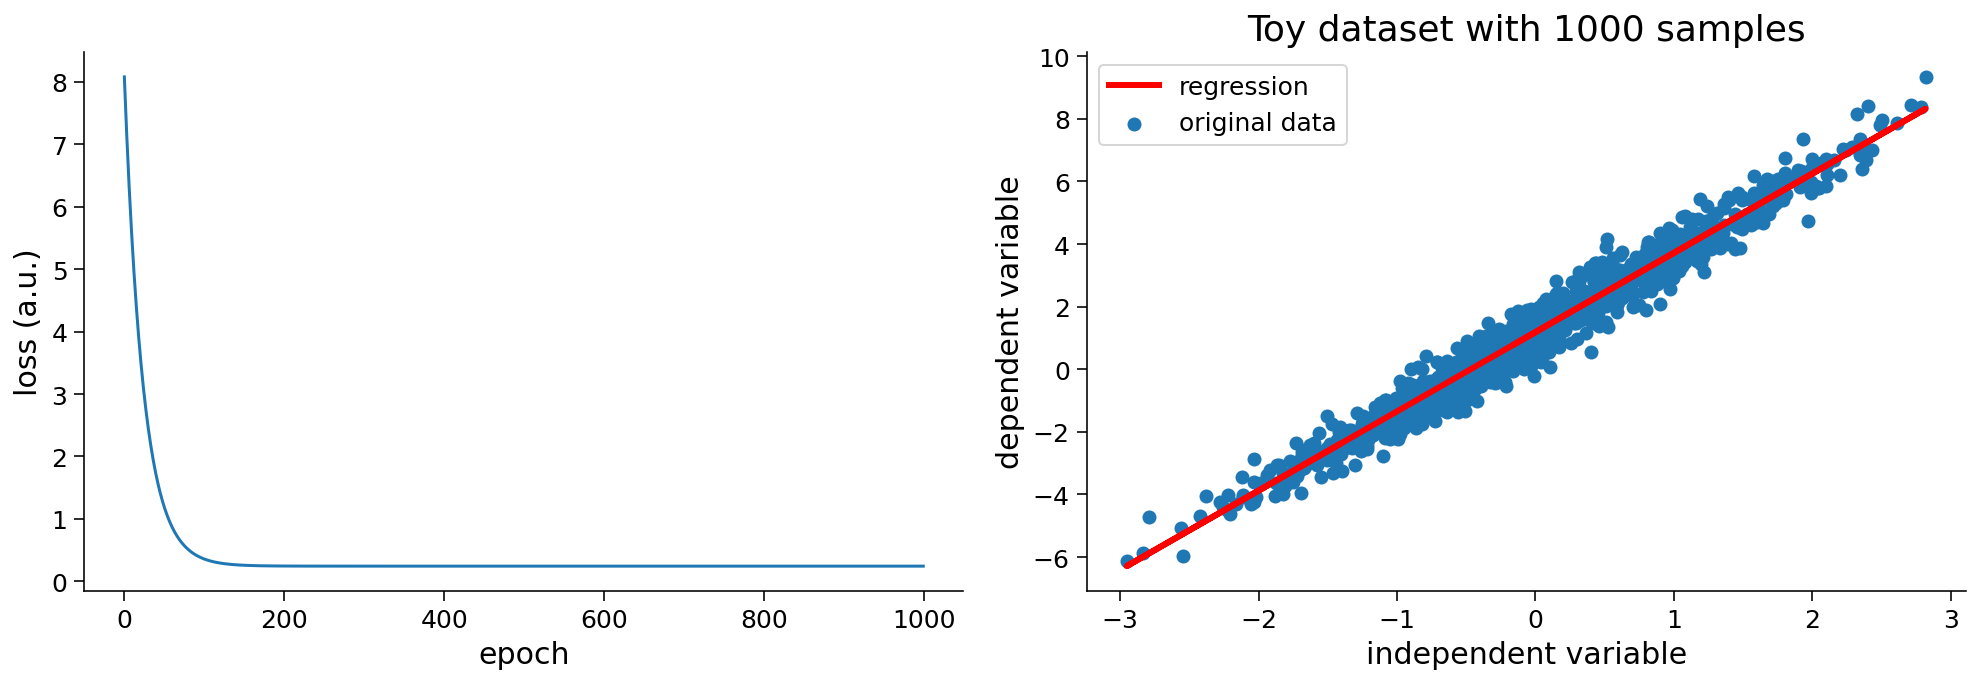

In [87]:
net = nn.Sequential(nn.Linear(1, 1))

net[0].weight.data.fill_(0)
net[0].bias.data.fill_(0)

loss = nn.MSELoss()

optimizer = torch.optim.SGD(net.parameters(), lr=1e-2)

losses = []

epoch_range = trange(num_epochs, desc="loss: ", leave=True)

for epoch in epoch_range:
    if losses:
        epoch_range.set_description("loss: {:.6f}".format(losses[-1]))
        epoch_range.refresh()  # to show immediately the update

    l = loss(net(X.T), y)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    l = loss(net(X.T), y)
    losses.append(l.detach())

y_hat = net(X.T).reshape(-1, 1)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), losses)
plt.xlabel("epoch")
plt.ylabel("loss (a.u.)")

plt.subplot(1, 2, 2)
plt.scatter(X, y, label="original data")
plt.plot(
    X.reshape(-1, 1), y_hat.detach(), label="regression", color="red", linewidth=3.0
)
plt.xlabel("independent variable")
plt.ylabel("dependent variable")
plt.title(f"Toy dataset with {N} samples")
plt.legend()
plt.show()


## Section 4.1: Model evaluation

We compare the model parameters learned by training the given data-set and the actual parameters generated by our dataset. To access parameters, we first access the layer that we need from the model (i.e., `net`) and then access that layer’s weights and bias. As in our from-scratch implementation, note that our estimated parameters are close to their ground-truth counterparts.


In [88]:
w_pytorch = net[0].weight.data
print("error in estimating w:", original_w - w_pytorch.reshape(original_w.shape))
b_pytorch = net[0].bias.data
print("error in estimating b:", original_b - b_pytorch)

print(
    f"Original w: {original_w}, from-scratch: {w_train.detach()}, pytorch: {w_pytorch}"
)
print(
    f"Original b: {original_b}, from-scratch: {b_train.detach()}, pytorch: {b_pytorch}"
)


X = X.cpu().detach().numpy()
y = y.cpu().detach().numpy()

# We append a row with ones
X_append = np.vstack((X, np.ones((1, 1000))))

# Check if the inverse matrix exists!!
params = analytical_sol(X_append.T, y)
if len(params) != 0:
    print(f"Original w: {original_w}, analytical: {params[0]}")
    print(f"Original b: {original_b}, analytical: {params[1]}")


error in estimating w: tensor([[-0.0301]])
error in estimating b: tensor([0.0153])
Original w: tensor([[2.5000]]), from-scratch: tensor([2.5301]), pytorch: tensor([[2.5301]])
Original b: 1.2, from-scratch: tensor([1.1847]), pytorch: tensor([1.1847])
Original w: tensor([[2.5000]]), analytical: [2.53014445]
Original b: 1.2, analytical: [1.18474046]


## Section 4.2: More features than the number of examples


Video available at https://youtube.com/watch?v=_uhMofhfYno


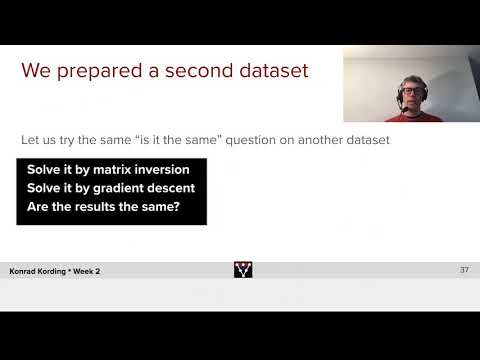

In [89]:
# @title Video: Linear Regression with More Dimensions than Data

video = YouTubeVideo(id="_uhMofhfYno", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video


But, what if we do not have enough data? And what about if the dataset is linearly dependent?


In [90]:
# Generate a second dataset with D>>N

original_w = torch.randn(200, 1).reshape(-1, 1)
original_b = 1.2
N = 10  # number of examples
X, y = synthetic_dataset(original_w, original_b, num_examples=N, sigma=0.5)

print(f"The dataset has N={X.shape[1]} examples in the {X.shape[0]}D space!")


The dataset has N=10 examples in the 200D space!


torch.Size([1, 200])


loss:   0%|          | 0/1000 [00:00<?, ?it/s]

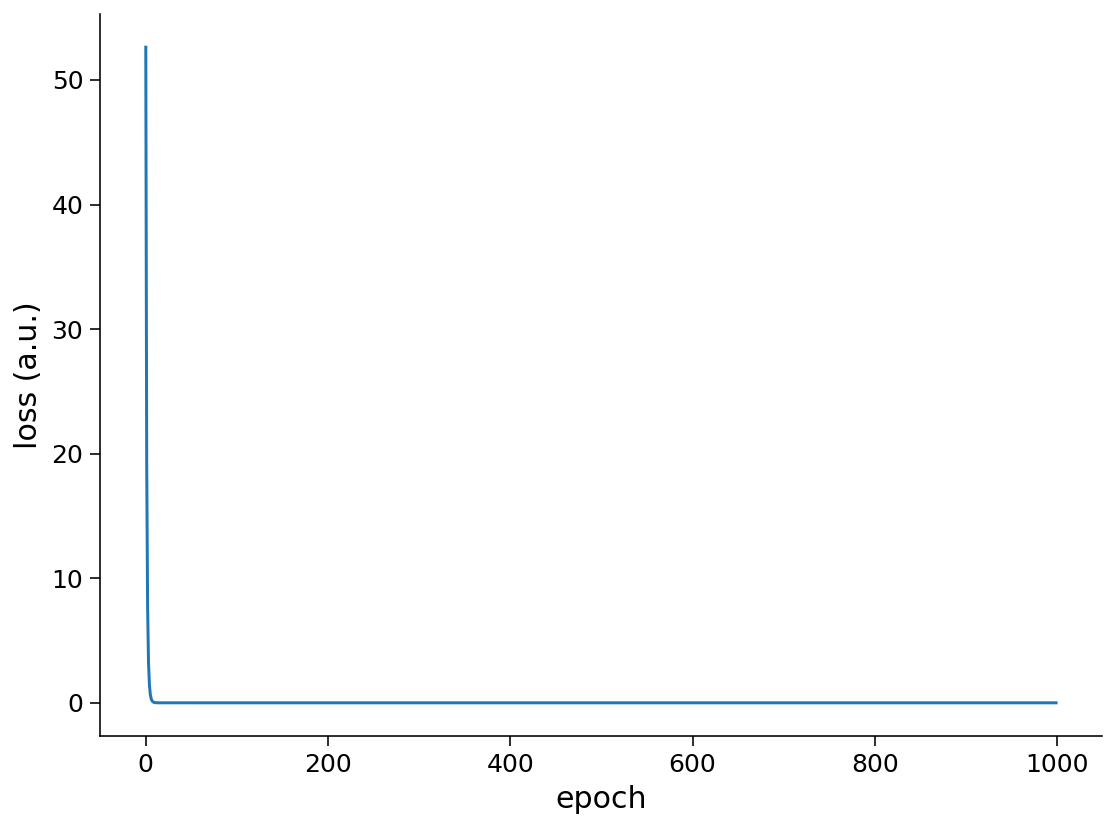

In [91]:
# Model construction
net = nn.Sequential(nn.Linear(X.shape[0], 1))

# Parameter initialization to zero
net[0].weight.data.fill_(0)
net[0].bias.data.fill_(0)
print(net[0].weight.shape)

loss = nn.MSELoss()

optimizer = torch.optim.SGD(net.parameters(), lr=1e-2)

losses = []

epoch_range = trange(num_epochs, desc="loss: ", leave=True)

for epoch in epoch_range:
    if losses:
        epoch_range.set_description("loss: {:.6f}".format(losses[-1]))
        epoch_range.refresh()  # to show immediately the update

    l = loss(net(X.T), y)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    l = loss(net(X.T), y)
    losses.append(l.detach())

y_hat = net(X.T).reshape(-1, 1)

plt.figure()
plt.plot(range(num_epochs), losses)
plt.xlabel("epoch")
plt.ylabel("loss (a.u.)")
plt.show()


Let's compute the analytic solution.


In [92]:
# Append a row with ones and take the transpose
X_append = np.vstack((X.detach(), np.ones((1, X.shape[1])))).T

# Analytical solution
params = analytical_sol(X_append, y.cpu().detach().numpy())
if len(params) != 0:
    print(f"Original w: {original_w}, analytical: {params[0]}")
    print(f"Original b: {original_b}, analytical: {params[1]}")


LinAlgError. Matrix is Singular. No analytical solution.


Video available at https://youtube.com/watch?v=FpcSTi9YITc


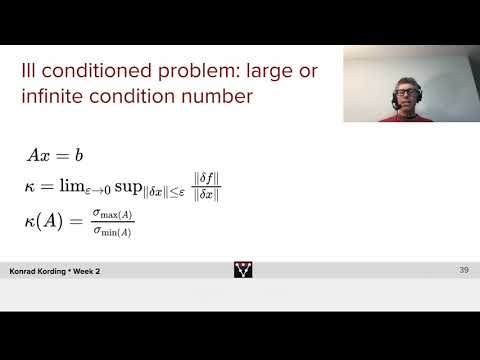

In [ ]:
# @title Video: Condition Numbers

video = YouTubeVideo(id="FpcSTi9YITc", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


---

# Quiz


A. Is 1, 2 or 3 the correct partial derivative $\frac{\partial f}{\partial x}$ of

$f(x, y)=(2 x-y)^{2}+\ln (x y)$?

1. $-2(2 x-y)+\frac{1}{y}$
2. $4(2 x-y)+\frac{1}{x}$
3. $2(2x-y)+\frac{1}{y}$


In [119]:
partial_derivative_1 = "2"  # @param {type:"string"}


B. Is 1, 2 or 3 the correct partial derivative $\frac{\partial f}{\partial y}$ of

$f(x, y)=4 \frac{x}{y^{5}}$?

1. $\frac{4}{y^{5}}$
2. $-20 \frac{x}{y^{6}}$
3. $4 \frac{x}{y^4}$


In [120]:
partial_derivative_2 = "2"  # @param {type:"string"}


C. Please write down three specific problems/scenarios for which you find autograd is useful.


In [121]:
autograd_uses = "1) a model with many parameters (hard to compute all gradients); 2) there is no close-form solution (or not easy to find) for the function; 3) faster, use of GPU"  # @param {type:"string"}


D. Now, go back to Section 3 and change the learning rate to a bigger number and see what happens. Change the learning rate to a smaller number and see what happens. What happens if you change the number of epochs to a higher or lower value? Why do you think this is happening?


In [122]:
lr_epochs_vs_convergence = "in general, a low lr makes the model to learn slowly, where only a small fraction of the gradient impacting the parameters; a large lr makes the model learn faster, but if this is too large it makes it unstable and sometimes not converging (this happens if lr close to 1.0); a larger number of epochs gives the model more room to keep improving, but it takes more time (and the opposite); a combination of a good lr and epochs could reach a loss that is already enough (not changing much)"  # @param {type:"string"}


E. In Section 3, did it matter whether you use matrix inversion or gradient descent?


In [123]:
matrix_gradient_same = "not in terms of loss; but the analytical solution was faster in this case; in section 4, though, some characteristics of the data made the inversion of the matrix fail"  # @param {type:"string"}


F. Which of the following statements about Gradient Descent is NOT true:

1. It is an iterative method
2. Follows negative gradients to minimize a continuous function
3. Makes small steps at each point towards a minimum
4. Does NOT perform well for large scale models (many variables)


In [124]:
gd_false_statement = "4"  # @param {type:"string"}


G. Which of the following is the correct order for the Gradient Descent training loop in PyTorch, 1, 2, 3, or 4?

> π: optimizer.zero_grad()

> ø: loss.backward()

> ß: loss = loss_fun(predictions, targets)

> Ω: predictions = model(features)

> ∆: optimizer.step()

1. π, ø, ß, Ω, ∆
2. Ω, ß, ø, π, ∆
3. π, Ω, ß, ∆, ø
4. π, Ω, ß, ø, ∆


In [125]:
gd_training_loop = "2"  # @param {type:"string"}


H. Imagine we are training a deep neural net. Should we try 1, 2, 3 or 4 if

> Ω: training loss is not improving

> ∆: training loss is not converging and is showing strange chaotic behaviour

1. Ω: smaller learning rate, ∆: smaller learning rate
2. Ω: larger learning rate, ∆: larger learning rate
3. Ω: smaller learning rate, ∆: larger learning rate
4. Ω: larger learning rate, ∆: smaller learning rate


In [126]:
nn_improvement = "4"  # @param {type:"string"}


---

# Wrap up


## Submit responses


In [127]:
# @markdown #Run Cell to Show Airtable Form
# @markdown ##**Confirm your answers and then click "Submit"**

import time
import numpy as np
from IPython.display import IFrame


def prefill_form(src, fields: dict):
    """
    src: the original src url to embed the form
    fields: a dictionary of field:value pairs,
    e.g. {"pennkey": my_pennkey, "location": my_location}
    """
    prefills = "&".join(["prefill_%s=%s" % (key, fields[key]) for key in fields])
    src = src + prefills
    src = "+".join(src.split(" "))
    return src


# autofill time if it is not present
try:
    t0
except NameError:
    t0 = time.time()
try:
    t1
except NameError:
    t1 = time.time()

# autofill fields if they are not present
# a missing pennkey and pod will result in an Airtable warning
# which is easily fixed user-side.
try:
    my_pennkey
except NameError:
    my_pennkey = ""
try:
    my_pod
except NameError:
    my_pod = ""
try:
    my_email
except NameError:
    my_email = ""
try:
    partial_derivative_1
except NameError:
    partial_derivative_1 = "Select"
try:
    partial_derivative_2
except NameError:
    partial_derivative_2 = "Select"
try:
    autograd_uses
except NameError:
    autograd_uses = ""
try:
    lr_epochs_vs_convergence
except NameError:
    lr_epochs_vs_convergence = ""
try:
    matrix_gradient_same
except NameError:
    matrix_gradient_same = ""

times = [(t - t0) for t in [t1]]

fields = {
    "pennkey": my_pennkey,
    "pod": my_pod,
    "email": my_email,
    "partial_derivative_1": partial_derivative_1,
    "partial_derivative_2": partial_derivative_2,
    "autograd_uses": autograd_uses,
    "lr_epochs_vs_convergence": lr_epochs_vs_convergence,
    "matrix_gradient_same": matrix_gradient_same,
    "gd_false_statement": gd_false_statement,
    "gd_training_loop": gd_training_loop,
    "nn_improvement": nn_improvement,
    "cumulative_times": times,
}

src = "https://airtable.com/embed/shrQOklRg7XufYTGf?"

# now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src=prefill_form(src, fields), width=800, height=400))


## Feedback

How could this session have been better? How do you feel right now?

Feel free to use the embeded form below:


In [128]:
# @markdown ##Run cell to show feedback form
# @markdown ####Confirm your answers and then click "Submit"

display(
    IFrame(
        src="https://airtable.com/embed/shr1TzujOOOY21kFQ?backgroundColor=red",
        width=800,
        height=400,
    )
)


---

<a name="proof"></a>

# Appendix: Linear Regression analytic solution - Proof

\begin{align}
\frac{\partial L(\textbf{w})}{\partial \textbf{w}} &{}= 0 \\
\frac{\partial }{\partial \textbf{w}}\left( \left( \textbf{Y} - \textbf{X}\textbf{w}\right)^{\text{T}} \left( \textbf{Y} - \textbf{X}\textbf{w}\right) \right) &{} = 0 \\
\frac{\partial }{\partial \textbf{w}}\left( \left( \textbf{Y}^{\text{T}} - \left( \textbf{X}\textbf{w} \right)^{\text{T}}\right) \left( \textbf{Y} - \textbf{X}\textbf{w}\right) \right) &{} = 0 \\
\frac{\partial }{\partial \textbf{w}} \left( \textbf{Y}^{\text{T}}\textbf{Y} -
\left( \textbf{X}\textbf{w} \right)^{\text{T}}\textbf{Y} - \textbf{Y}^{\text{T}}\left( \textbf{X}\textbf{w}\right)+ \textbf{w}\textbf{X}^{\text{T}}\textbf{X}\textbf{w} \right)&{}= 0
\end{align}

Here, we need to make some simplifications on the second term in the left-hand side. We know that $\textbf{X} \in \mathbb{R}^{N \times D+1}, \textbf{w} \in \mathbb{R}^{D+1 \times 1}$, therefore their product $\in \mathbb{R}^{N \times 1}$. Thus, the dimensions of the second order is $1$, i.e., $ \left( \textbf{X}\textbf{w} \right)^{\text{T}} \in \mathbb{R}$. This means that the second order is a scalar.

Thus, we can substitute with its transpose, i.e., $\left( \left( \textbf{X}\textbf{w} \right)^{\text{T}} \textbf{Y} \right)^{\text{T}} = \textbf{Y}^{\text{T}} \left( \textbf{X}\textbf{w} \right)$. So the derivative is simplified in:

\begin{align}
\frac{\partial }{\partial \textbf{w}} \left( \textbf{Y}^{\text{T}}\textbf{Y} -\textbf{Y}^{\text{T}} \left( \textbf{X}\textbf{w} \right) - \textbf{Y}^{\text{T}} \left( \textbf{X}\textbf{w} \right) + \textbf{w}^{\text{T}}\textbf{X}^{\text{T}}\textbf{X}\textbf{w} \right)&{}= 0 \\
\frac{\partial }{\partial \textbf{w}} \left( \textbf{Y}^{\text{T}}\textbf{Y} -2\textbf{Y}^{\text{T}} \left( \textbf{X}\textbf{w} \right) + \textbf{w}^{\text{T}}\textbf{X}^{\text{T}}\textbf{X}\textbf{w} \right)&{}= 0 \\
\frac{\partial }{\partial \textbf{w}} \left( \textbf{Y}^{\text{T}}\textbf{Y} -2\left( \textbf{X}^{\text{T}}\textbf{Y} \right)^{\text{T}} \textbf{w} + \textbf{w}^{\text{T}}\textbf{X}^{\text{T}}\textbf{X}\textbf{w} \right)&{}= 0 \\
-2\textbf{X}^{\text{T}}\textbf{Y} + 2\textbf{X}^{\text{T}}\textbf{X}\textbf{w} &{}= 0
\end{align}

Assuming that $\textbf{X}^{\text{T}}\textbf{X}$ is full-rank and thus its inverse exists (implying that $N>D$ and the rows are not all linearly dependent:

\begin{equation}
\textbf{w}^{\textbf{\*}} = \left( \textbf{X}^{\text{T}}\textbf{X} \right)^{-1}\textbf{X}^{\text{T}}\textbf{Y}
\end{equation}

For the solution, we have used the following identities:

_Derivative of a linear function_

\begin{equation}
\frac{\partial }{\partial \vec{x}} \vec{\alpha}\vec{x} = \frac{\partial }{\partial \vec{x}} \vec{\alpha}^{\text{T}}\vec{x} = \frac{\partial }{\partial \vec{x}} \vec{x}^{\text{T}} \vec{\alpha} = \vec{\alpha}
\end{equation}

_(Think of calculus: $\frac{d}{dx}(\alpha x)=\alpha$)_

_Derivative of a quadratic function_

\begin{equation}
\frac{\partial }{\partial \vec{x}} \vec{x}^{\text{T}}A \vec{x} = (A + A^{\text{T}}) \vec{x}
\end{equation}

where if $A=A^{\text{T}}$, i.e., $A$ is symmetric, then

\begin{equation}
\frac{\partial }{\partial \vec{x}} \vec{x}^{\text{T}}A \vec{x} = 2A \vec{x}
\end{equation}

_(Think of calculus: $\frac{d}{dx}(\alpha x^2)=2 \alpha x$)_
